In [1]:
import pandas as pd 
import os
import re
import numpy as np

from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from PIL import Image

In [2]:
BASE_PATH = os.path.join(os.getcwd(), os.pardir)
DATA_PATH = os.path.join(BASE_PATH, 'data')

In [3]:
train_df = pd.read_json('imputed_train.json')

In [6]:
test_df = pd.read_json(os.path.join(DATA_PATH, 'test.json.zip'))

# Extract text/numerical/categorical features

Let's extract out the number of bathrooms and bedrooms, the latitude, the longitude, and the price since these are trivial to extract as vthey are numerical features

In [7]:
bathrooms_train = train_df['bathrooms']
bedrooms_train = train_df['bedrooms']
latitudes_train = train_df['latitude']
longitudes_train = train_df['longitude']
prices_train = train_df['price']

In [8]:
bathrooms_test = test_df['bathrooms']
bedrooms_test = test_df['bedrooms']
latitudes_test = test_df['latitude']
longitudes_test = test_df['longitude']
prices_test = test_df['price']

Now we can extract the month, day, hour and weekday from the creation timestamp

In [9]:
datetime_train = pd.to_datetime(train_df['created'])

In [10]:
datetime = pd.to_datetime(test_df['created'])

In [11]:
months_train = datetime_train.dt.month
days_train = datetime_train.dt.day
hours_train = datetime_train.dt.hour

In [12]:
# Where Monday = 0, and Sunday = 6
weekdays_train = datetime_train.dt.dayofweek

In [13]:
datetime_test = pd.to_datetime(test_df['created'])

In [14]:
months_test = datetime_test.dt.month
days_test = datetime_test.dt.day
hours_test = datetime_test.dt.hour

In [15]:
# Where Monday = 0, and Sunday = 6
weekdays_test = datetime_test.dt.dayofweek

Now we can extract the number of pictures for each listing

In [16]:
num_photos_train = train_df['photos'].str.len()

In [17]:
num_photos_test = test_df['photos'].str.len()

We can also extract the number of features for each listing as well as the number of words in the description

In [18]:
num_features_train = train_df['features'].apply(len)

In [19]:
num_features_test = test_df['features'].apply(len)

In [20]:
num_description_train = train_df['description'].apply(lambda x: len(x.split(" ")))

In [21]:
num_description_test = test_df['description'].apply(lambda x: len(x.split(" ")))

Now we must encode our categorical features, display_address, manager_id, building_id and street_address

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
enc = OneHotEncoder(handle_unknown='ignore')

In [24]:
enc.fit(train_df[['display_address', 'manager_id', 'building_id', 'street_address']])

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [25]:
categorical_feats_train = enc.transform(train_df[['display_address', 'manager_id', 'building_id', 'street_address']]).toarray()

In [26]:
categorical_feats_test = enc.transform(test_df[['display_address', 'manager_id', 'building_id', 'street_address']]).toarray()

Now let's extract the 'features' column, which is a harder task

Methodology of: https://www.kaggle.com/jxnlco/deduplicating-features

In [27]:
features = train_df['features'].apply(lambda x: [i.lower() for i in x])

We eliminate all features that appear less than $n$ times

In [28]:
n = 5

feature_counts = Counter()
for feature in features.tolist():
    feature_counts.update(feature)
feature = sorted([k for (k,v) in feature_counts.items() if v > n])
feature[:10]

['24/7 concierge',
 '24/7 doorman',
 '24hr doorman',
 'a full service luxury highrise',
 'actual apt. photos',
 'air conditioning',
 'all utilities included',
 'assigned-parking-space',
 'attended lobby',
 'backyard']

Since we have a lot of duplicates, we can clean things up to eliminate them. We use the first 4 characters of a feature in order to group together different features.

In [29]:
def clean(s):
    x = s.replace("-", "")
    x = x.replace(" ", "")
    x = x.replace("twenty four hour", "24")
    x = x.replace("24/7", "24")
    x = x.replace("24hr", "24")
    x = x.replace("24-hour", "24")
    x = x.replace("24hour", "24")
    x = x.replace("24 hour", "24")
    x = x.replace("common", "cm")
    x = x.replace("concierge", "doorman")
    x = x.replace("bicycle", "bike")
    x = x.replace("private", "pv")
    x = x.replace("deco", "dc")
    x = x.replace("decorative", "dc")
    x = x.replace("onsite", "os")
    x = x.replace("outdoor", "od")
    x = x.replace("ss appliances", "stainless")
    return x

def feature_hash(x):
    cleaned = clean(x, uniq)
    key = cleaned[:4].strip()
    return key

In [30]:
key2original = defaultdict(list)
k = 4
for f in feature:
    cleaned = clean(f)
    key = cleaned[:k].strip()
    key2original[key].append(f)

In [31]:
key2original

defaultdict(list,
            {'24do': ['24/7 concierge', '24/7 doorman', '24hr doorman'],
             'aful': ['a full service luxury highrise'],
             'actu': ['actual apt. photos'],
             'airc': ['air conditioning'],
             'allu': ['all utilities included'],
             'assi': ['assigned-parking-space'],
             'atte': ['attended lobby'],
             'back': ['backyard'],
             'balc': ['balcony'],
             'base': ['basement storage'],
             'bike': ['bike room', 'bike storage'],
             'bill': ['billiards room'],
             'brea': ['breakfast bar'],
             'brow': ['brownstone'],
             'buil': ['building-common-outdoor-space'],
             'busi': ['business center'],
             'cabl': ['cable/satellite tv'],
             'cats': ['cats allowed'],
             'cent': ['central a/c', 'central ac', 'central air'],
             'chef': ['chefs kitchen'],
             'chil': ["children's playroom", 'children

In [32]:
columns = list(key2original.keys())

In [33]:
original2key = {}
for col in columns:
    for original in key2original[col]:
        original2key[original] = col

In [34]:
original2key

{'24/7 concierge': '24do',
 '24/7 doorman': '24do',
 '24hr doorman': '24do',
 'a full service luxury highrise': 'aful',
 'actual apt. photos': 'actu',
 'air conditioning': 'airc',
 'all utilities included': 'allu',
 'assigned-parking-space': 'assi',
 'attended lobby': 'atte',
 'backyard': 'back',
 'balcony': 'balc',
 'basement storage': 'base',
 'bike room': 'bike',
 'bike storage': 'bike',
 'billiards room': 'bill',
 'breakfast bar': 'brea',
 'brownstone': 'brow',
 'building-common-outdoor-space': 'buil',
 'business center': 'busi',
 'cable/satellite tv': 'cabl',
 'cats allowed': 'cats',
 'central a/c': 'cent',
 'central ac': 'cent',
 'central air': 'cent',
 'chefs kitchen': 'chef',
 "children's playroom": 'chil',
 'childrens playroom': 'chil',
 'cinema room': 'cine',
 'city view': 'city',
 'close to subway': 'clos',
 'closets galore!': 'clos',
 'common backyard': 'cmba',
 'common garden': 'cmga',
 'common outdoor space': 'cmod',
 'common parking/garage': 'cmpa',
 'common roof deck': 

In [35]:
all_listing_features = {}

for index,row in train_df.iterrows():
    listing_features = {}
    features_found = []
    for feature in row['features']:
        feature = feature.lower()
        if feature in original2key:
            features_found.append(original2key[feature])
    for feature in columns:
            if feature not in features_found:
                listing_features[feature] = 0
            else:
                listing_features[feature] = 1
    all_listing_features[row['listing_id']] = listing_features
    
one_hot_features_train = pd.DataFrame.from_dict(all_listing_features, orient='index')

In [36]:
one_hot_features_train

24do  aful  actu  airc  allu  assi  atte  back  balc  base  ...  \
7211212     0     0     0     0     0     0     0     0     0     0  ...   
7150865     0     0     0     0     0     0     0     0     0     0  ...   
6887163     0     0     0     0     0     0     0     0     0     0  ...   
6888711     0     0     0     0     0     0     0     0     0     0  ...   
6934781     0     0     0     0     0     0     0     0     0     0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
7098690     0     0     0     0     0     0     0     0     0     0  ...   
6822449     0     0     0     0     0     0     0     0     0     0  ...   
6881461     0     0     0     0     0     0     0     0     0     0  ...   
6841891     0     0     0     0     0     0     0     0     0     0  ...   
6858245     0     0     0     0     0     0     0     0     0     0  ...   

         tons  vale  vide  view  virt  walk  wash  whee  wifi  wood  
7211212     0     0     0     0     0     0     0     0     0     0  
7150865     0     0     0     0     0     0     0     0     0     0  
6887163     0     0     0     0     0     0     0     0     0     0  
6888711     0     0     0     0     0     0     0     0     0     0  
6934781     0     0     0     0     0     0     0     0     0     0  
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
7098690     0     0     0     0     0     0     0     0     0     0  
6822449     0     0     0     0     0     0     0     0     0     0  
6881461     0     0     0     0     0     0     0     0     0     0  
6841891     0     0     0     0     0     0     0     0     0     0  
6858245     0     0     0     0     0     0     0     0     0     0  

[49308 rows x 145 columns]

In [37]:
all_listing_features = {}

for index,row in test_df.iterrows():
    listing_features = {}
    features_found = []
    for feature in row['features']:
        feature = feature.lower()
        if feature in original2key:
            features_found.append(original2key[feature])
    for feature in columns:
            if feature not in features_found:
                listing_features[feature] = 0
            else:
                listing_features[feature] = 1
    all_listing_features[row['listing_id']] = listing_features
    
one_hot_features_test = pd.DataFrame.from_dict(all_listing_features, orient='index')

In [38]:
one_hot_features_test

24do  aful  actu  airc  allu  assi  atte  back  balc  base  ...  \
7142618     0     0     0     0     0     0     0     0     0     0  ...   
7210040     0     0     0     0     0     0     0     0     0     0  ...   
7174566     0     0     0     0     0     0     0     0     0     0  ...   
7191391     0     0     0     0     0     0     0     0     0     0  ...   
7171695     0     0     0     0     0     0     0     0     0     0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
6928108     0     0     0     0     0     0     0     0     0     0  ...   
6906674     0     0     0     0     0     0     0     0     0     0  ...   
6897967     0     0     0     0     0     0     0     0     0     0  ...   
6842183     0     0     0     0     0     0     0     0     0     0  ...   
6889319     0     0     0     0     0     0     0     0     0     0  ...   

         tons  vale  vide  view  virt  walk  wash  whee  wifi  wood  
7142618     0     0     0     0     0     0     0     0     0     0  
7210040     0     0     0     0     0     0     0     0     0     0  
7174566     0     0     0     0     0     0     0     0     0     0  
7191391     0     0     0     0     0     0     0     0     0     0  
7171695     0     0     0     0     0     0     0     1     0     0  
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
6928108     0     0     0     0     0     0     0     0     0     0  
6906674     0     0     0     0     0     0     0     0     0     0  
6897967     0     0     0     0     0     0     0     0     0     0  
6842183     0     0     0     0     0     0     0     0     0     0  
6889319     0     0     0     0     0     0     0     0     0     0  

[74659 rows x 145 columns]

Now we can try extracting features from the "Description" column

Methodology of: https://www.kaggle.com/ug2409/using-description-as-the-only-feature-72-cv

In [39]:
descriptions_train = train_df[['description']]

In [40]:
# Removes symbols, numbers and stem the words to reduce dimentional space
stemmer = PorterStemmer()

def clean(x):
    regex = re.compile('[^a-zA-Z ]')
    # For user clarity, broken it into three steps
    i = regex.sub(' ', x).lower()
    i = i.split(" ") 
    i= [stemmer.stem(l) for l in i]
    i= " ".join([l.strip() for l in i if (len(l)>2) ]) # Keeping words that have length greater than 2
    return i

In [41]:
descriptions_train['description_new'] = descriptions_train.description.apply(lambda x: clean(x))

/Users/ronniehung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
descriptions_train.head()

description  \
10      A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
10000                                                       
100004  Top Top West Village location, beautiful Pre-w...   
100007  Building Amenities - Garage - Garden - fitness...   
100013  Beautifully renovated 3 bedroom flex 4 bedroom...   

                                          description_new  
10      brand new bedroom bath apartmentenjoy these fo...  
10000                                                      
100004  top top west villag locat beauti pre war build...  
100007  build amen garag garden fit room laundri room ...  
100013  beauti renov bedroom flex bedroom apart for re...

In [43]:
from sklearn.feature_extraction.text import CountVectorizer #Can use tfidffvectorizer as well

cvect_desc = CountVectorizer(stop_words='english', max_features=200)
full_sparse = cvect_desc.fit_transform(descriptions_train.description_new)

# Renaming words to avoid collisions with other feature names in the model
col_desc = ['desc_'+ i for i in cvect_desc.get_feature_names()] 
count_vect_df = pd.DataFrame(full_sparse.todense(), columns=col_desc)
descriptions_train = pd.concat([descriptions_train.reset_index(), count_vect_df],axis=1)

In [44]:
descriptions_train = descriptions_train.drop(labels=['description', 'index', 'description_new'], axis=1)

In [45]:
descriptions_train.index = train_df['listing_id']
descriptions_train

desc_access  desc_allow  desc_amaz  desc_amen  desc_amp  desc_ani  \
listing_id                                                                      
7211212               0           0          0          0         0         0   
7150865               0           0          0          0         0         0   
6887163               0           0          0          0         0         1   
6888711               0           0          0          1         0         0   
6934781               0           0          0          0         0         0   
...                 ...         ...        ...        ...       ...       ...   
7098690               1           0          1          0         0         0   
6822449               1           0          0          0         0         0   
6881461               0           0          0          0         0         0   
6841891               1           0          0          1         0         0   
6858245               0           0          0          0         0         0   

            desc_apart  desc_applianc  desc_appoint  desc_area  ...  \
listing_id                                                      ...   
7211212              2              1             0          1  ...   
7150865              0              0             0          0  ...   
6887163              2              0             0          0  ...   
6888711              1              0             0          1  ...   
6934781              3              1             1          0  ...   
...                ...            ...           ...        ...  ...   
7098690              0              0             0          1  ...   
6822449              1              1             0          0  ...   
6881461              2              2             0          0  ...   
6841891              2              0             0          0  ...   
6858245              2              1             0          0  ...   

            desc_walk  desc_wall  desc_washer  desc_water  desc_websit  \
listing_id                                                               
7211212             0          0            1           0            1   
7150865             0          0            0           0            0   
6887163             0          0            0           0            1   
6888711             1          0            0           0            1   
6934781             0          2            1           0            0   
...               ...        ...          ...         ...          ...   
7098690             0          0            0           0            1   
6822449             0          0            0           0            0   
6881461             0          0            0           0            3   
6841891             1          0            0           0            3   
6858245             0          0            0           0            1   

            desc_west  desc_white  desc_window  desc_wood  desc_york  
listing_id                                                            
7211212             0           0            0          0          0  
7150865             0           0            0          0          0  
6887163             1           0            0          0          1  
6888711             0           0            0          0          0  
6934781             0           0            0          1          0  
...               ...         ...          ...        ...        ...  
7098690             0           0            0          0          0  
6822449             0           0            1          0          0  
6881461             1           0            0          0          0  
6841891             0           0            0          0          0  
6858245             0           0            0          0          1  

[49308 rows x 200 columns]

In [46]:
descriptions_test = test_df[['description']]

In [47]:
# Removes symbols, numbers and stem the words to reduce dimentional space
stemmer = PorterStemmer()

def clean(x):
    regex = re.compile('[^a-zA-Z ]')
    # For user clarity, broken it into three steps
    i = regex.sub(' ', x).lower()
    i = i.split(" ") 
    i= [stemmer.stem(l) for l in i]
    i= " ".join([l.strip() for l in i if (len(l)>2) ]) # Keeping words that have length greater than 2
    return i

In [48]:
descriptions_test['description_new'] = descriptions_test.description.apply(lambda x: clean(x))

/Users/ronniehung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
descriptions_test.head()

description  \
0  Large with awesome terrace--accessible via bed...   
1  Prime Soho - between Bleecker and Houston - Ne...   
2  Spacious studio in Prime Location. Cleanbuildi...   
3  For immediate access call Bryan.<br /><br />Bo...   
5  Beautiful TRUE 1 bedroom in a luxury building ...   

                                     description_new  
0  larg with awesom terrac access via bedroom and...  
1  prime soho between bleecker and houston newli ...  
2  spaciou studio prime locat cleanbuild with han...  
3  for immedi access call bryan bond new york rea...  
5  beauti true bedroom luxuri build the financi d...

In [50]:
full_sparse = cvect_desc.transform(descriptions_test.description_new)

# Renaming words to avoid collisions with other feature names in the model
col_desc = ['desc_'+ i for i in cvect_desc.get_feature_names()] 
count_vect_df = pd.DataFrame(full_sparse.todense(), columns=col_desc)
descriptions_test = pd.concat([descriptions_test.reset_index(), count_vect_df],axis=1)

In [51]:
descriptions_test = descriptions_test.drop(labels=['description', 'index', 'description_new'], axis=1)

In [52]:
descriptions_test.index = test_df['listing_id']
descriptions_test

desc_access  desc_allow  desc_amaz  desc_amen  desc_amp  desc_ani  \
listing_id                                                                      
7142618               1           0          0          0         0         0   
7210040               0           0          0          0         0         0   
7174566               0           0          0          0         0         0   
7191391               1           0          0          0         0         0   
7171695               0           0          0          1         0         0   
...                 ...         ...        ...        ...       ...       ...   
6928108               1           0          0          0         0         0   
6906674               0           0          0          0         0         0   
6897967               0           0          0          0         0         0   
6842183               3           0          0          1         2         0   
6889319               0           0          0          0         0         0   

            desc_apart  desc_applianc  desc_appoint  desc_area  ...  \
listing_id                                                      ...   
7142618              1              0             0          0  ...   
7210040              0              1             0          0  ...   
7174566              0              0             1          0  ...   
7191391              0              0             0          0  ...   
7171695              1              1             1          0  ...   
...                ...            ...           ...        ...  ...   
6928108              1              0             0          0  ...   
6906674              1              0             0          0  ...   
6897967              1              1             0          0  ...   
6842183              2              0             0          1  ...   
6889319              0              0             0          0  ...   

            desc_walk  desc_wall  desc_washer  desc_water  desc_websit  \
listing_id                                                               
7142618             0          0            0           0            1   
7210040             0          0            0           0            0   
7174566             0          0            0           0            0   
7191391             0          0            0           0            1   
7171695             0          0            0           1            1   
...               ...        ...          ...         ...          ...   
6928108             1          0            0           0            0   
6906674             0          1            0           0            1   
6897967             0          0            0           0            0   
6842183             0          0            0           0            0   
6889319             0          0            0           0            1   

            desc_west  desc_white  desc_window  desc_wood  desc_york  
listing_id                                                            
7142618             0           0            0          0          0  
7210040             0           0            0          0          0  
7174566             0           0            0          0          0  
7191391             0           0            0          0          1  
7171695             0           0            0          1          0  
...               ...         ...          ...        ...        ...  
6928108             0           0            0          0          0  
6906674             0           0            0          0          0  
6897967             0           0            0          0          0  
6842183             0           0            0          0          1  
6889319             0           0            0          0          1  

[74659 rows x 200 columns]

Now we can make one final dataframe which has all the columns. We can perform feature selection on this at a later time.

In [53]:
final_train_df = pd.DataFrame()

In [54]:
final_train_df['bathrooms'] = bathrooms_train
final_train_df['bedrooms'] = bedrooms_train
final_train_df['latitudes'] = latitudes_train
final_train_df['longitudes'] = longitudes_train
final_train_df['prices'] = prices_train

In [55]:
final_train_df['months'] = months_train
final_train_df['days'] = days_train
final_train_df['hours'] = hours_train
final_train_df['weekdays'] = weekdays_train

In [56]:
final_train_df['num_photos'] = num_photos_train

In [57]:
final_train_df.index = train_df['listing_id']
final_train_df

bathrooms  bedrooms  latitudes  longitudes  prices  months  days  \
listing_id                                                                     
7211212           1.5         3    40.7145    -73.9425    3000       6    24   
7150865           1.0         2    40.7947    -73.9667    5465       6    12   
6887163           1.0         1    40.7388    -74.0018    2850       4    17   
6888711           1.0         1    40.7539    -73.9677    3275       4    18   
6934781           1.0         4    40.8241    -73.9493    3350       4    28   
...               ...       ...        ...         ...     ...     ...   ...   
7098690           1.0         2    40.7426    -73.9790    3200       6     2   
6822449           1.0         1    40.7102    -74.0163    3950       4     4   
6881461           1.0         1    40.7601    -73.9900    2595       4    16   
6841891           1.0         0    40.7066    -74.0101    3350       4     8   
6858245           1.0         2    40.8699    -73.9172    2200       4    12   

            hours  weekdays  num_photos  
listing_id                               
7211212         7         4           5  
7150865        12         6          11  
6887163         3         6           8  
6888711         2         0           3  
6934781         1         3           3  
...           ...       ...         ...  
7098690         5         3           4  
6822449        18         0           8  
6881461         2         5           3  
6841891         2         4           9  
6858245         2         1           7  

[49308 rows x 10 columns]

In [58]:
categorical_feats_df_train = pd.DataFrame(categorical_feats_train, columns=enc.get_feature_names(), index=train_df['listing_id'])

In [59]:
final_train_df.merge(categorical_feats_df_train, left_index=True, right_index=True)

bathrooms  bedrooms  latitudes  longitudes  prices  months  days  \
listing_id                                                                     
7211212           1.5         3    40.7145    -73.9425    3000       6    24   
7150865           1.0         2    40.7947    -73.9667    5465       6    12   
6887163           1.0         1    40.7388    -74.0018    2850       4    17   
6888711           1.0         1    40.7539    -73.9677    3275       4    18   
6934781           1.0         4    40.8241    -73.9493    3350       4    28   
...               ...       ...        ...         ...     ...     ...   ...   
7098690           1.0         2    40.7426    -73.9790    3200       6     2   
6822449           1.0         1    40.7102    -74.0163    3950       4     4   
6881461           1.0         1    40.7601    -73.9900    2595       4    16   
6841891           1.0         0    40.7066    -74.0101    3350       4     8   
6858245           1.0         2    40.8699    -73.9172    2200       4    12   

            hours  weekdays  num_photos  ...  \
listing_id                               ...   
7211212         7         4           5  ...   
7150865        12         6          11  ...   
6887163         3         6           8  ...   
6888711         2         0           3  ...   
6934781         1         3           3  ...   
...           ...       ...         ...  ...   
7098690         5         3           4  ...   
6822449        18         0           8  ...   
6881461         2         5           3  ...   
6841891         2         4           9  ...   
6858245         2         1           7  ...   

            x3_waverly street and charles street  \
listing_id                                         
7211212                                      0.0   
7150865                                      0.0   
6887163                                      0.0   
6888711                                      0.0   
6934781                                      0.0   
...                                          ...   
7098690                                      0.0   
6822449                                      0.0   
6881461                                      0.0   
6841891                                      0.0   
6858245                                      0.0   

            x3_west 18th street and 7th avenue  x3_west 29 street & 8 ave   \
listing_id                                                                   
7211212                                    0.0                         0.0   
7150865                                    0.0                         0.0   
6887163                                    0.0                         0.0   
6888711                                    0.0                         0.0   
6934781                                    0.0                         0.0   
...                                        ...                         ...   
7098690                                    0.0                         0.0   
6822449                                    0.0                         0.0   
6881461                                    0.0                         0.0   
6841891                                    0.0                         0.0   
6858245                                    0.0                         0.0   

            x3_west 45  x3_west 49th street and 9th avenue  \
listing_id                                                   
7211212            0.0                                 0.0   
7150865            0.0                                 0.0   
6887163            0.0                                 0.0   
6888711            0.0                                 0.0   
6934781            0.0                                 0.0   
...                ...                                 ...   
7098690            0.0                                 0.0   
6822449            0.0                                 0.0   
6881461            0.0            

In [60]:
final_train_df = final_train_df.merge(descriptions_train, left_index=True, right_index=True)

In [61]:
final_train_df = final_train_df.merge(one_hot_features_train, left_index=True, right_index=True)

Now we can perform one-hot encoding on the building_ids and manager_ids

In [62]:
final_train_df = pd.concat([final_train_df, pd.get_dummies(final_train_df['building_ids'], prefix='building')], axis=1)
final_train_df = pd.concat([final_train_df, pd.get_dummies(final_train_df['manager_ids'], prefix='manager')], axis=1)

KeyError: 'building_ids'

In [63]:
final_train_df = final_train_df.drop(['building_ids', 'manager_ids'], axis=1)

KeyError: "['building_ids' 'manager_ids'] not found in axis"

In [64]:
final_train_df

bathrooms  bedrooms  latitudes  longitudes  prices  months  days  \
7211212        1.5         3    40.7145    -73.9425    3000       6    24   
7150865        1.0         2    40.7947    -73.9667    5465       6    12   
6887163        1.0         1    40.7388    -74.0018    2850       4    17   
6888711        1.0         1    40.7539    -73.9677    3275       4    18   
6934781        1.0         4    40.8241    -73.9493    3350       4    28   
...            ...       ...        ...         ...     ...     ...   ...   
7098690        1.0         2    40.7426    -73.9790    3200       6     2   
6822449        1.0         1    40.7102    -74.0163    3950       4     4   
6881461        1.0         1    40.7601    -73.9900    2595       4    16   
6841891        1.0         0    40.7066    -74.0101    3350       4     8   
6858245        1.0         2    40.8699    -73.9172    2200       4    12   

         hours  weekdays  num_photos  ...  tons  vale  vide  view  virt  walk  \
7211212      7         4           5  ...     0     0     0     0     0     0   
7150865     12         6          11  ...     0     0     0     0     0     0   
6887163      3         6           8  ...     0     0     0     0     0     0   
6888711      2         0           3  ...     0     0     0     0     0     0   
6934781      1         3           3  ...     0     0     0     0     0     0   
...        ...       ...         ...  ...   ...   ...   ...   ...   ...   ...   
7098690      5         3           4  ...     0     0     0     0     0     0   
6822449     18         0           8  ...     0     0     0     0     0     0   
6881461      2         5           3  ...     0     0     0     0     0     0   
6841891      2         4           9  ...     0     0     0     0     0     0   
6858245      2         1           7  ...     0     0     0     0     0     0   

         wash  whee  wifi  wood  
7211212     0     0     0     0  
7150865     0     0     0     0  
6887163     0     0     0     0  
6888711     0     0     0     0  
6934781     0     0     0     0  
...       ...   ...   ...   ...  
7098690     0     0     0     0  
6822449     0     0     0     0  
6881461     0     0     0     0  
6841891     0     0     0     0  
6858245     0     0     0     0  

[49308 rows x 355 columns]

In [65]:
final_train_df.to_csv(os.path.join(DATA_PATH, 'training_feats.tsv'), sep='\t')

In [39]:
train_df.interest_level.to_csv(os.path.join(DATA_PATH, 'training_labels.tsv'), sep='\t')

/home/matthew/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


Let's calculate the mutual information for the target variable to get a head start on feature selection

In [34]:
from sklearn.feature_selection import mutual_info_classif

In [56]:
# For the main features
mutual_info_classif(final_train_df[['bathrooms', 'bedrooms', 'latitudes', 'longitudes', 'prices',
                                    'months', 'days', 'hours', 'weekdays', 'num_photos']], 
                                   train_df['interest_level'], random_state=667)

array([0.01400252, 0.00873072, 0.04042343, 0.03000614, 0.05876936,
       0.00231721, 0.00469537, 0.03053344, 0.        , 0.02422371])

We see that 'weekday' has a mutual info value of 0, meaning it is not important and is independent from the target labels. Now let's check this out for the one-hot encoded features

In [60]:
values = mutual_info_classif(descriptions, train_df['interest_level'], random_state=667)
values

array([3.07965841e-03, 0.00000000e+00, 2.61793018e-03, 3.58251950e-03,
       5.83791054e-03, 0.00000000e+00, 4.01113097e-05, 4.17201904e-03,
       1.15129589e-04, 0.00000000e+00, 8.91575917e-04, 0.00000000e+00,
       2.77387634e-04, 0.00000000e+00, 3.25647799e-03, 0.00000000e+00,
       5.58796287e-04, 0.00000000e+00, 4.91915044e-03, 2.71003189e-03,
       1.89450293e-03, 1.93635995e-03, 0.00000000e+00, 2.82918069e-03,
       2.46602156e-03, 2.38778741e-04, 0.00000000e+00, 0.00000000e+00,
       3.64035226e-03, 0.00000000e+00, 6.84479465e-04, 2.01959702e-03,
       0.00000000e+00, 2.00550262e-03, 1.76325343e-03, 2.13647306e-03,
       0.00000000e+00, 7.69864350e-03, 1.25789563e-03, 2.42976194e-03,
       3.02932437e-03, 4.18282236e-03, 0.00000000e+00, 4.80206172e-04,
       1.13388700e-03, 2.66789812e-03, 4.79801710e-04, 0.00000000e+00,
       3.61480463e-03, 1.40578760e-03, 3.28071620e-04, 3.62588906e-03,
       0.00000000e+00, 3.40291265e-03, 0.00000000e+00, 0.00000000e+00,
      

In [61]:
max(values)

0.014328444988887634

In [62]:
values = mutual_info_classif(one_hot_features, train_df['interest_level'], random_state=667)
values

array([0.00000000e+00, 1.22475661e-03, 1.49649635e-03, 6.15803149e-06,
       1.32427565e-03, 1.55443608e-03, 0.00000000e+00, 0.00000000e+00,
       3.75819580e-03, 0.00000000e+00, 1.54171636e-03, 0.00000000e+00,
       2.29911354e-03, 9.97463401e-04, 0.00000000e+00, 2.31064414e-03,
       0.00000000e+00, 5.50238527e-03, 3.37911356e-04, 2.48216600e-03,
       0.00000000e+00, 3.37525363e-04, 0.00000000e+00, 0.00000000e+00,
       1.02898991e-03, 0.00000000e+00, 0.00000000e+00, 2.14312623e-03,
       0.00000000e+00, 0.00000000e+00, 1.00316834e-04, 1.19715118e-03,
       1.81247249e-03, 3.85060802e-04, 4.18661599e-04, 0.00000000e+00,
       1.71899494e-03, 4.64816689e-05, 2.86926992e-03, 9.14897964e-03,
       3.12241634e-03, 3.73253873e-03, 1.69926372e-03, 1.36427271e-03,
       0.00000000e+00, 6.94981495e-03, 0.00000000e+00, 1.71508013e-03,
       1.99342688e-03, 1.72881301e-03, 0.00000000e+00, 1.10106051e-03,
       0.00000000e+00, 1.89643738e-03, 6.30424542e-03, 0.00000000e+00,
      

In [63]:
max(values)

0.013985754946577611

In [49]:
# Output it to a csv
# final_train_df.to_csv(os.path.join(DATA_PATH, 'train_feats.tsv'), sep='\t')
final_train_df.to_json(os.path.join(DATA_PATH, 'train_feats.json'))

# Extract image data 

## Creating a new dataframe for images

Included with the Kaggle dataset is a sample of photos for 100 listings. We want to create a new dataframe for these images, so that we can organize the data, as well as find new, interesting features.

In [35]:
IMG_PATH = os.path.join(DATA_PATH, 'images_sample')

In [47]:
# Each folder is a listing ID
img_folders = os.listdir(IMG_PATH)

In [51]:
# img_df has two columns for now
# img -> the actual Image object itself
# listing_id -> references the original listing that the photo belongs to
img_df = pd.DataFrame(columns=['image', 'listing_id'])
img_df

In [59]:
# Iterate over all folders (listing id)
for img_folder in img_folders:
    
    img_dir = os.path.join(IMG_PATH, img_folder)
    all_imgs = os.listdir(img_dir)
    
    # Iterate over all images inside each folder
    for img in all_imgs:
        img_path = os.path.join(img_dir, img)
        row = {'image': None, 'listing_id': None}
        row['listing_id'] = img_folder
        
        # Create an Image object using the Pillow library, then save into dataframe
        row['image'] = Image.open(img_path)
        img_df = img_df.append(row, ignore_index = True)

In [62]:
img_df.head()

image listing_id
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...    6811957
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...    6811957
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...    6811957
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...    6811957
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...    6811957

## Image exploration

In [134]:
img_df.iloc[0]

image         <PIL.JpegImagePlugin.JpegImageFile image mode=...
listing_id                                              6811957
Name: 0, dtype: object

In [67]:
img = img_df.iloc[0].image

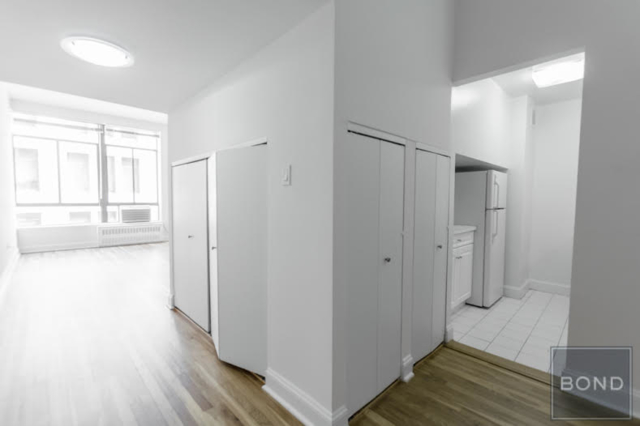

In [68]:
img

We can extract RGB pixel values as each color image has 3 channels.

In [69]:
r,g,b = img.split()

As an example, we show the blue channel.

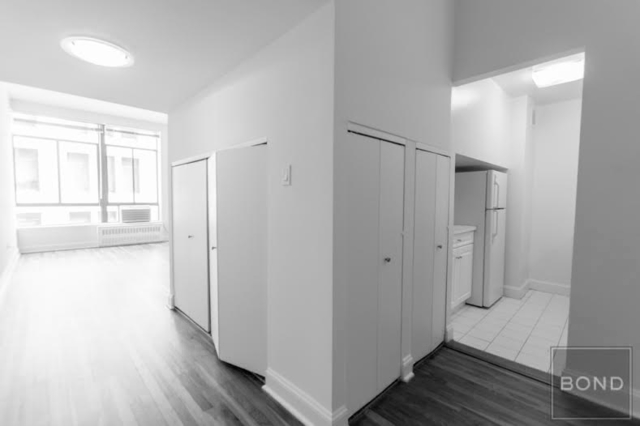

In [75]:
b

Note that the blue channel is simply a monochrome image in and of itself. That's because there is only one channel. 

Now we can calculate some basic statistics for the images which may (or may not) be useful in predicting interest level.

### Mean and standard deviation

We can separately compute the mean and standard deviation for each of the three channels. This yields 3*2 = 6 new features.

In [88]:
r_arr = np.array(r.getdata())
g_arr = np.array(g.getdata())
b_arr = np.array(b.getdata())

In [89]:
r_mean = r_arr.mean()
g_mean = g_arr.mean()
b_mean = b_arr.mean()

In [90]:
# The mean red pixel value for the entire image.
r_mean

178.78016431924883

In [91]:
r_std = r_arr.std()
g_std = g_arr.std()
b_std = b_arr.std()

In [100]:
# Standard deviation for the green pixel value.
g_std

44.596423661626275

## Color histogram
For each channel, we can compute the distribution, which allows us to construct a histogram as follows.

In [106]:
r_hist = r.histogram()
g_hist = g.histogram()
b_hist = b.histogram()

<Figure size 432x288 with 0 Axes>

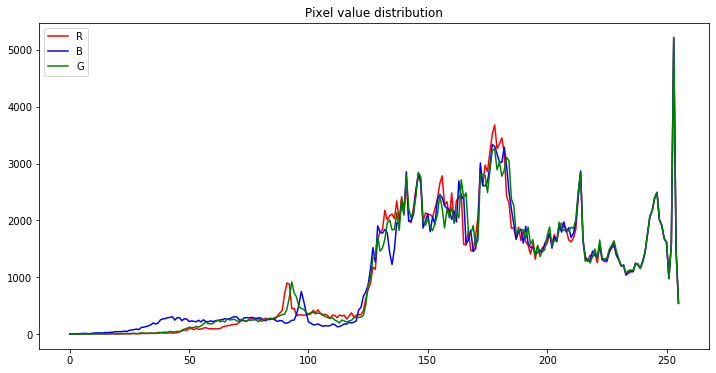

In [139]:
plt.clf()
plt.figure(figsize=(12,6))
plt.plot(r_hist, c='red', label='R')
plt.plot(b_hist, c='blue', label='B')
plt.plot(g_hist, c='green', label='G')
plt.title("Pixel value distribution")
plt.legend()
plt.show()

The histogram itself might be useful as a feature, but since each histogram consists of 256 numbers and there are 3 histograms, this is too many features. Instead, we can find the most dominant pixel value for each channel (i.e. the argmax).

This gives us 3 additional features, for a running total of 9.

In [109]:
r_dom = np.argmax(r_hist)
g_dom = np.argmax(g_hist)
b_dom = np.argmax(b_hist)

In [110]:
# Most dominant value in the blue channel
b_dom

253

## Dominant color

While calculating statistics for each channel separately might yield nine features, these values are somewhat misleading in that they do not consider the other two channels. It is clear that none of the color channels are independent from any other.

Thus, it may be more informative to look at all 3 channels at once (i.e. treat each pixel as a 3-vector). However, rather than trying to calculate the mean or standard deviation, we can find the most "dominant" color. This could mean one of two things:

1) Compute the most frequent RGB vector, in a similar manner as computing r_dom, g_dom and b_dom.

2) Use k-means clustering to find the most dominant RGB vector.

https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image

## Standard approach
The first approach is to do a raw count of each 3-tuple (R, G, B) that occurs in the image, and take the maximum.

In [124]:
pixel_values = np.array(img.getdata())

In [125]:
pixel_values

array([[202, 202, 202],
       [202, 202, 202],
       [202, 202, 202],
       ...,
       [ 64,  55,  40],
       [ 64,  55,  38],
       [ 64,  55,  40]])

In [128]:
# Computes the mode row of a 2-dimensional matrix.
# taken from 
# https://stackoverflow.com/questions/43554819/find-most-frequent-row-or-mode-of-a-matrix-of-vectors-python-numpy

def mode_rows(a):
    a = np.ascontiguousarray(a)
    void_dt = np.dtype((np.void, a.dtype.itemsize * np.prod(a.shape[1:])))
    _,ids, count = np.unique(a.view(void_dt).ravel(), \
                                return_index=1,return_counts=1)
    largest_count_id = ids[count.argmax()]
    most_frequent_row = a[largest_count_id]
    return most_frequent_row

In [129]:
dominant_mode = mode_rows(pixel_values)
dominant_mode

array([253, 253, 253])

## K-means clustering
We use the following Python snippet obtained from https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image to calculate the dominant color.

First we find cluster centres via k-means clustering. # of clusters is set to 5. Then we assign each pixel to one of the clusters (based on which cluster centre is closest). Finally, we count the size of each cluster, and take the maximum.

In [104]:
import scipy
import scipy.misc
import scipy.cluster
import binascii

In [105]:
NUM_CLUSTERS = 5

print('reading image')
im = img
im = im.resize((150, 150))      # optional, to reduce time
ar = np.asarray(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))

reading image
finding clusters
cluster centres:
 [[209.39292196 210.05898367 209.74319419]
 [242.43389918 242.47916667 242.47196502]
 [175.90558531 177.0544759  176.27666412]
 [ 91.46115906  85.16091245  67.69605425]
 [142.62923764 142.74698197 141.41210518]]
most frequent is [175.90558531 177.0544759  176.27666412] (#afb1b0)


In [133]:
# Dominant cluster centre is float, so round then convert to int
dominant_kmeans = np.round(peak).astype(int)
dominant_kmeans

array([176, 177, 176])

Note that the most frequent pixel value (253, 253, 253) is significantly different from the dominant color found by k-means clustering (176, 177, 176). The k-means dominant color can roughly be interpreted as the most dominant "representative" color out of the five representative colors (which are the centroids of the k-means algorithm). Since the computation of the centroids uses the entire dataset, the k-means dominant color may be slightly more informative than simply using the mode pixel.